In [1]:
import pandas as pd
import json
from transformers import AutoTokenizer
import os
import openai
import bs4
from more_itertools import chunked, flatten
import re
from pprint import pprint
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
from collections import defaultdict
import tiktoken
import numpy as np
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2
openai.api_key = open('/Users/offendo/.openai-key', 'r').read()

# Dataset Creation

In [2]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base')

In [3]:
def bio_to_xml(tokens, tags):
    """
    Convert BIO tags to XML format as a list of tokens.
    
    Args:
        tokens (list): List of tokens (words).
        tags (list): List of BIO tags corresponding to each token.
        
    Returns:
        list: XML representation of the tagged entities as a list of tokens.
    """
    
    xml_tokens = []
    current_entity = None
    current_entity_tokens = []

    for token, tag in zip(tokens, tags):
        if tag.startswith("B-"):  # Beginning of a new entity
            # Close the previous entity tag if there is one
            if current_entity:
                xml_tokens.append(f"<{current_entity}>")
                xml_tokens.extend(current_entity_tokens)
                xml_tokens.append(f"</{current_entity}>")
            # Start a new entity
            current_entity = tag[2:]
            current_entity_tokens = [token]
        elif tag.startswith("I-") and current_entity == tag[2:]:  # Inside the same entity
            current_entity_tokens.append(token)
        else:  # Outside any entity
            # Close the previous entity tag if there is one
            if current_entity:
                xml_tokens.append(f"<{current_entity}>")
                xml_tokens.extend(current_entity_tokens)
                xml_tokens.append(f"</{current_entity}>")
                current_entity = None
                current_entity_tokens = []
            # Add the token outside any tag
            xml_tokens.append(token)

    # Close any remaining entity tag at the end
    if current_entity:
        xml_tokens.append(f"<{current_entity}>")
        xml_tokens.extend(current_entity_tokens)
        xml_tokens.append(f"</{current_entity}>")
        
    return xml_tokens


In [4]:
def convert_iob_to_xml(json_file, tokenizer):
    with open(json_file, 'r') as f:
        data = json.load(f)
    labels = ['definition', 'theorem', 'example', 'proof']
    tokens = []
    joined_tags = []
    for token, tags in data['iob_tags']:
        filtered_tags = [t.replace('B-', '').replace('I-', '') for t in tags]
        filtered_tags = [t for t in filtered_tags if t in labels]
        begin = any([t.startswith('B-') for t in tags if t.strip('B').strip('I').strip('-') in labels])
        joined = '-'.join(sorted(filtered_tags)) or 'O'
        if joined != 'O':
            joined = 'B-' + joined if begin else 'I-' + joined
        if len(joined_tags) > 1 and joined.replace('B-', '') == joined_tags[-1].replace('B-', '').replace('I-', ''):
            joined = joined.replace('B-', 'I-')
        joined_tags.append(joined)
        tokens.append(token)

    xml_result = bio_to_xml(tokens, joined_tags)
    inputs = tokenizer.convert_tokens_to_string(tokens)
    response = tokenizer.convert_tokens_to_string(xml_result)
    return {'prompt': inputs, 'completion': response}

In [5]:
def bio_to_entities(tokens, tags, tokenizer):
    entities = {}
    current_entity = []
    current_label = None

    for token, tag in zip(tokens, tags):
        if tag.startswith("B-"):
            # Start of a new entity
            if current_entity and current_label:
                # Add the previous entity to the result
                entity_str = tokenizer.convert_tokens_to_string(current_entity)
                entities.setdefault(current_label, []).append(entity_str)
            current_entity = [token]
            current_label = tag[2:]
        elif tag.startswith("I-") and current_label == tag[2:]:
            # Continuation of the current entity
            current_entity.append(token)
        else:
            # End of an entity
            if current_entity and current_label:
                entity_str = tokenizer.convert_tokens_to_string(current_entity)
                entities.setdefault(current_label, []).append(entity_str)
            current_entity = []
            current_label = None
            if tag.startswith("B-"):
                current_entity = [token]
                current_label = tag[2:]

    # Add the last entity if there is one
    if current_entity and current_label:
        entity_str = tokenizer.convert_tokens_to_string(current_entity)
        entities.setdefault(current_label, []).append(entity_str)

    return entities


In [6]:
def convert_iob_to_json(json_file, tokenizer, maxlen: int = None):
    with open(json_file, 'r') as f:
        data = json.load(f)

    examples = []
    maxlen = maxlen or 9999999999
    for chunk in chunked(data['iob_tags'], n=maxlen):
        entities = dict(definition=[], theorem=[], example=[], proof=[])
        current_def = []
        current_theorem = []
        current_example = []
        current_proof = []
        tokens = []
        for token, tags in chunk:
            tokens.append(token)
            for tag in tags:
                if tag.startswith('B-') and 'definition' in tag:
                    if current_def:
                        entity_str = tokenizer.convert_tokens_to_string(current_def)
                        entities['definition'].append(entity_str)
                    current_def = [token]
                if tag.startswith('I-') and 'definition' in tag:
                    current_def.append(token)
                    
                if tag.startswith('B-') and 'theorem' in tag:
                    if current_theorem:
                        entity_str = tokenizer.convert_tokens_to_string(current_theorem)
                        entities['theorem'].append(entity_str)
                    current_theorem = [token]
                if tag.startswith('I-') and 'theorem' in tag:
                    current_theorem.append(token)
                    
                if tag.startswith('B-') and 'example' in tag:
                    if current_example:
                        entity_str = tokenizer.convert_tokens_to_string(current_example)
                        entities['example'].append(entity_str)
                    current_example = [token]
                if tag.startswith('I-') and 'example' in tag:
                    current_example.append(token)    
                    
                if tag.startswith('B-') and 'proof' in tag:
                    if current_proof:
                        entity_str = tokenizer.convert_tokens_to_string(current_proof)
                        entities['proof'].append(entity_str)
                    current_proof = [token]
                if tag.startswith('I-') and 'proof' in tag:
                    current_proof.append(token)
    
        if current_def:
            entities['definition'].append(tokenizer.convert_tokens_to_string(current_def))
        if current_theorem:
            entities['theorem'].append(tokenizer.convert_tokens_to_string(current_theorem))
        if current_example:
            entities['example'].append(tokenizer.convert_tokens_to_string(current_example))
        if current_proof:
            entities['proof'].append(tokenizer.convert_tokens_to_string(current_proof))
            
        inputs = tokenizer.convert_tokens_to_string(tokens)
        response = json.dumps(entities)
        example = {'prompt': inputs, 'completion': response}
        examples.append(example)
    return examples

In [58]:
trains = []
for file in os.listdir('./data/roberta-base-new-data/train/'):
    trains.extend(convert_iob_to_json(f'./data/roberta-base-new-data/train/{file}', tokenizer, 1024))

vals = []
for file in os.listdir('./data/roberta-base-new-data/val/'):
    vals.extend(convert_iob_to_json(f'./data/roberta-base-new-data/val/{file}', tokenizer, 1024))

test = []
for file in os.listdir('./data/roberta-base-new-data/test/'):
    test.extend(convert_iob_to_json(f'./data/roberta-base-new-data/test/{file}', tokenizer, 1024))

In [59]:
train = pd.DataFrame(trains)
val = pd.DataFrame(vals)
test = pd.DataFrame(test)

train.to_json('./data/openai/train.jsonl', orient='records', lines=True)
val.to_json('./data/openai/val.jsonl', orient='records', lines=True)
test.to_json('./data/openai/test.jsonl', orient='records', lines=True)

# Few-shot Prompting Results

In [60]:
def generate_bio_tags(sentence, entities):
    # Tokenize the sentence by splitting on spaces and punctuation, while keeping the tokens intact
    tokens = re.findall(r"\w+|[^\w\s]", sentence, re.UNICODE)
    tags = [[] for _ in range(len(tokens))]

    for entity_type, entity_list in entities.items():
        for entity in entity_list:
            # Tokenize the entity name in the same way to match against tokens
            entity_tokens = re.findall(r"\w+|[^\w\s]", entity, re.UNICODE)
            entity_len = len(entity_tokens)
            # Search for the entity tokens in the sentence tokens
            for i in range(len(tokens) - entity_len + 1):
                if tokens[i:i + entity_len] == entity_tokens:
                    for j in range(entity_len):
                        tags[i + j].append(f"{entity_type}")
                    break  # Move to the next entity once found
    joined_tags = ['-'.join(sorted(set(t))) if len(t) > 0 else 'O' for t in tags]
    return tokens, joined_tags

In [61]:
def score_model_output(path):
    df = pd.read_json(path, lines=True)
    df['predictions'] = df['predictions'].apply(lambda x: json.loads(x))
    df['completion'] = df['completion'].apply(lambda x: json.loads(x.replace("<|endoftext|>", "")))
    preds = {}
    for p in df.predictions:
        for k in p.keys():
            preds[k] = preds.get(k, []) + p[k]
    golds = {}
    for g in df.completion:
        for k in g.keys():
            golds[k] = golds.get(k, []) + g[k]
    tokens, gold_tags = generate_bio_tags(' '.join(df.prompt), golds)
    tokens, pred_tags = generate_bio_tags(' '.join(df.prompt), preds)
    labels = [t for t in set(gold_tags) if t != 'O']
    p, r, f, _ = precision_recall_fscore_support(gold_tags, pred_tags, average=None, labels=labels)
    mp, mr, mf, _ = precision_recall_fscore_support(gold_tags, pred_tags, average='micro', labels=labels)

    result = pd.DataFrame({'tokens': tokens, 'golds': gold_tags, 'preds': pred_tags})
    metrics = dict(
        precision=dict(zip(labels, p)),
        recall=dict(zip(labels, r)),
        f1=dict(zip(labels, f)),
        micro_precision=mp,
        micro_recall=mr,
        micro_f1=mf,
    )
    return metrics, result

In [41]:
metrics, outputs = score_model_output('./results/openai-gpt-3.5-turbo.5shot.val.jsonl')
pprint(metrics)

{'f1': {'definition': 0.13625,
        'definition-theorem': 0.0,
        'example': 0.7440476190476191,
        'proof': 0.46064889174429813,
        'proof-theorem': 0.0,
        'theorem': 0.14026402640264027},
 'micro_f1': 0.304661079253051,
 'micro_precision': 0.7754491017964071,
 'micro_recall': 0.18956999085086917,
 'precision': {'definition': 1.0,
               'definition-theorem': 0.0,
               'example': 0.6157635467980296,
               'proof': 0.8056179775280898,
               'proof-theorem': 0.0,
               'theorem': 0.6343283582089553},
 'recall': {'definition': 0.07310529845741114,
            'definition-theorem': 0.0,
            'example': 0.9398496240601504,
            'proof': 0.3225371120107962,
            'proof-theorem': 0.0,
            'theorem': 0.07884972170686456}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [147]:
metrics, outputs = score_model_output('./results/openai-gpt-4-turbo.5shot.val.jsonl')
pprint(metrics)

{'f1': {'definition': 0.42953472690492245,
        'definition-theorem': 0.0,
        'example': 0.8632478632478633,
        'proof': 0.7035126504544338,
        'proof-theorem': 0.0,
        'theorem': 0.4852492370295015},
 'micro_f1': 0.541474890048072,
 'micro_precision': 0.6138682745825603,
 'micro_recall': 0.48435498627630375,
 'precision': {'definition': 0.43186440677966104,
               'definition-theorem': 0.0,
               'example': 1.0,
               'proof': 0.7748917748917749,
               'proof-theorem': 0.0,
               'theorem': 0.5371621621621622},
 'recall': {'definition': 0.4272300469483568,
            'definition-theorem': 0.0,
            'example': 0.7593984962406015,
            'proof': 0.644174538911381,
            'proof-theorem': 0.0,
            'theorem': 0.4424860853432282}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [148]:
metrics, outputs = score_model_output('./results/openai-gpt-4o-mini.5shot.val.jsonl')
pprint(metrics)

{'f1': {'definition': 0.5944418276024493,
        'definition-theorem': 0.0,
        'example': 0.0,
        'proof': 0.3002645502645503,
        'proof-theorem': 0.0,
        'theorem': 0.38411910669975186},
 'micro_f1': 0.3757498404594767,
 'micro_precision': 0.6210970464135022,
 'micro_recall': 0.26935041171088747,
 'precision': {'definition': 0.9984177215189873,
               'definition-theorem': 0.0,
               'example': 0.0,
               'proof': 0.5667915106117354,
               'proof-theorem': 0.0,
               'theorem': 0.41302027748132336},
 'recall': {'definition': 0.4232059020791415,
            'definition-theorem': 0.0,
            'example': 0.0,
            'proof': 0.20422852001799371,
            'proof-theorem': 0.0,
            'theorem': 0.3589981447124304}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [149]:
metrics, outputs = score_model_output('./results/openai-gpt-4o.5shot.val.jsonl')
pprint(metrics)

{'f1': {'definition': 0.6274199920979849,
        'definition-theorem': 0.0,
        'example': 0.5859030837004405,
        'proof': 0.6983471074380165,
        'proof-theorem': 0.0,
        'theorem': 0.49830508474576274},
 'micro_f1': 0.5934329660739609,
 'micro_precision': 0.7347379794705564,
 'micro_recall': 0.4977127172918573,
 'precision': {'definition': 0.7634615384615384,
               'definition-theorem': 0.0,
               'example': 0.4143302180685358,
               'proof': 0.8198908429351122,
               'proof-theorem': 0.0,
               'theorem': 0.6372832369942196},
 'recall': {'definition': 0.5325285043594903,
            'definition-theorem': 0.0,
            'example': 1.0,
            'proof': 0.6081871345029239,
            'proof-theorem': 0.0,
            'theorem': 0.4090909090909091}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [150]:
metrics, outputs = score_model_output('./results/openai-o1-mini.val-fixed.jsonl')
pprint(metrics)

{'f1': {'definition': 0.5504241281809613,
        'definition-theorem': 0.0,
        'example': 0.18815331010452963,
        'proof': 0.6437793427230047,
        'proof-theorem': 0.0,
        'theorem': 0.2773837667454689},
 'micro_f1': 0.4940991345397325,
 'micro_precision': 0.8718186024988431,
 'micro_recall': 0.34473924977127174,
 'precision': {'definition': 0.9255150554675119,
               'definition-theorem': 0.0,
               'example': 0.17532467532467533,
               'proof': 0.9257383966244725,
               'proof-theorem': 0.0,
               'theorem': 0.9214659685863874},
 'recall': {'definition': 0.39168343393695504,
            'definition-theorem': 0.0,
            'example': 0.20300751879699247,
            'proof': 0.49347728295096716,
            'proof-theorem': 0.0,
            'theorem': 0.16326530612244897}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [151]:
metrics, outputs = score_model_output('./results/openai-o1-mini.5shot.val-fixed.jsonl')
pprint(metrics)

{'f1': {'definition': 0.1524609843937575,
        'definition-theorem': 0.0,
        'example': 0.0,
        'proof': 0.35690968443960824,
        'proof-theorem': 0.0,
        'theorem': 0.23993558776167473},
 'micro_f1': 0.2423477437677501,
 'micro_precision': 0.8797250859106529,
 'micro_recall': 0.14053064958828912,
 'precision': {'definition': 0.7257142857142858,
               'definition-theorem': 0.0,
               'example': 0.0,
               'proof': 0.9213483146067416,
               'proof-theorem': 0.0,
               'theorem': 0.9085365853658537},
 'recall': {'definition': 0.085177733065057,
            'definition-theorem': 0.0,
            'example': 0.0,
            'proof': 0.2213225371120108,
            'proof-theorem': 0.0,
            'theorem': 0.13821892393320964}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [152]:
metrics, outputs = score_model_output('./results/openai-o1-preview.val-fixed.jsonl')
pprint(metrics)

{'f1': {'definition': 0.6172506738544474,
        'definition-theorem': 0.0,
        'example': 0.7208672086720868,
        'proof': 0.6985842985842986,
        'proof-theorem': 0.0,
        'theorem': 0.46497584541062803},
 'micro_f1': 0.5900506678949793,
 'micro_precision': 0.7958993476234856,
 'micro_recall': 0.4688014638609332,
 'precision': {'definition': 0.9346938775510204,
               'definition-theorem': 0.0,
               'example': 0.5635593220338984,
               'proof': 0.8164861612515042,
               'proof-theorem': 0.0,
               'theorem': 0.6660899653979239},
 'recall': {'definition': 0.4607645875251509,
            'definition-theorem': 0.0,
            'example': 1.0,
            'proof': 0.6104363472784525,
            'proof-theorem': 0.0,
            'theorem': 0.35714285714285715}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [153]:
outputs.to_csv(f'results/openai-o1-preview.val.outputs.csv', sep='\t', index=False)
!column -t -s $'\t' results/openai-o1-preview.val.outputs.csv > results/openai-o1-preview.txt

In [154]:
metrics, outputs = score_model_output('./results/openai-o1-preview.5shot.val-fixed.jsonl')
pprint(metrics)

{'f1': {'definition': 0.5888704318936877,
        'definition-theorem': 0.0,
        'example': 0.3878787878787879,
        'proof': 0.8414690841469085,
        'proof-theorem': 0.0,
        'theorem': 0.6076086956521739},
 'micro_f1': 0.664956168484071,
 'micro_precision': 0.7996914373875033,
 'micro_recall': 0.5690759377859104,
 'precision': {'definition': 0.7731733914940022,
               'definition-theorem': 0.0,
               'example': 1.0,
               'proof': 0.8706108706108706,
               'proof-theorem': 0.0,
               'theorem': 0.7335958005249343},
 'recall': {'definition': 0.4755197853789403,
            'definition-theorem': 0.0,
            'example': 0.24060150375939848,
            'proof': 0.8142150247413406,
            'proof-theorem': 0.0,
            'theorem': 0.5185528756957328}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [155]:
outputs.to_csv(f'results/openai-o1-preview.5shot.val.outputs.csv', sep='\t', index=False)
!column -t -s $'\t' results/openai-o1-preview.5shot.val.outputs.csv > results/openai-o1-preview.5shot.txt

# Fine-tuning

In [62]:
INST = """In the following LaTeX document, extract entities of the following types and return them in JSON output.
1. definition
2. theorem
3. proof
4. example
Your output should be a single JSON with 4 keys corresponding to the 4 entity types above. Spans may be part of multiple entities. Do not hallucinate text.
"""
SYST = "You are an expert mathematician who is fluent in reading LaTeX and extracting information."

In [63]:
def make_example_message(prompt, completion, instruction, system):
    messages = [{'role': 'system', 'content': system}]
    messages += [{'role': 'user', 'content': instruction + '\n\n' + prompt}]
    messages += [{'role': 'assistant', 'content': completion}]
    return {'messages': messages}

In [64]:
train_ms = train.apply(lambda row: make_example_message(row.prompt, row.completion, INST, SYST), axis=1).tolist()
val_ms = val.apply(lambda row: make_example_message(row.prompt, row.completion, INST, SYST), axis=1).tolist()
test_ms = test.apply(lambda row: make_example_message(row.prompt, row.completion, INST, SYST), axis=1).tolist()

In [65]:
pd.DataFrame.from_records(train_ms).to_json('./data/openai/texner-finetune.train.jsonl', orient='records', lines=True)
pd.DataFrame.from_records(val_ms).to_json('./data/openai/texner-finetune.val.jsonl', orient='records', lines=True)
pd.DataFrame.from_records(test_ms).to_json('./data/openai/texner-finetune.test.jsonl', orient='records', lines=True)

In [66]:
def format_error_check(dataset):
    # Format error checks
    format_errors = defaultdict(int)
    
    for ex in dataset:
        if not isinstance(ex, dict):
            format_errors["data_type"] += 1
            continue
            
        messages = ex.get("messages", None)
        if not messages:
            format_errors["missing_messages_list"] += 1
            continue
            
        for message in messages:
            if "role" not in message or "content" not in message:
                format_errors["message_missing_key"] += 1
            
            if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
                format_errors["message_unrecognized_key"] += 1
            
            if message.get("role", None) not in ("system", "user", "assistant", "function"):
                format_errors["unrecognized_role"] += 1
                
            content = message.get("content", None)
            function_call = message.get("function_call", None)
            
            if (not content and not function_call) or not isinstance(content, str):
                format_errors["missing_content"] += 1
        
        if not any(message.get("role", None) == "assistant" for message in messages):
            format_errors["example_missing_assistant_message"] += 1
    
    if format_errors:
        print("Found errors:")
        for k, v in format_errors.items():
            print(f"{k}: {v}")
    else:
        print("No errors found")

In [67]:
format_error_check(train_ms)
format_error_check(val_ms)
format_error_check(test_ms)

No errors found
No errors found
No errors found


In [68]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in train_ms:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 16385 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 16,385 token limit, they will be truncated during fine-tuning")
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 16385

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(train_ms)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 128, 2288
mean / median: 1543.8515625, 1798.5
p5 / p95: 472.00000000000006, 2107.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 17, 1232
mean / median: 704.8984375, 771.5
p5 / p95: 160.9, 1045.1

0 examples may be over the 16,385 token limit, they will be truncated during fine-tuning
Dataset has ~197613 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~592839 tokens


In [69]:
from openai import OpenAI
client = OpenAI()

train_file = client.files.create(
  file=open("data/openai/texner-finetune.train.jsonl", "rb"),
  purpose="fine-tune"
)
val_file = client.files.create(
  file=open("data/openai/texner-finetune.val.jsonl", "rb"),
  purpose="fine-tune"
)
test_file = client.files.create(
  file=open("data/openai/texner-finetune.test.jsonl", "rb"),
  purpose="fine-tune"
)

In [70]:
job = client.fine_tuning.jobs.create(
  training_file=train_file.id,
  model="gpt-4o-mini-2024-07-18",
  validation_file=val_file.id,
  seed=1299874447
)

In [71]:
job

FineTuningJob(id='ftjob-wkFvqSR6uSjhMb7OPgJvB2ky', created_at=1731131624, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-WEn9XU2tXbsjLzHzQeX2qlo4', result_files=[], seed=1299874447, status='validating_files', trained_tokens=None, training_file='file-UhPhFQSBWZJ4C7tzbEQnPipq', validation_file='file-wajDXEn6MriZp3hf2hn6JpFA', estimated_finish=None, integrations=[], user_provided_suffix=None)

In [72]:
# After fine-tuning, find this value from the openai dashboard
# MODEL = "ft:gpt-4o-mini-2024-07-18:uc-santa-cruz-jlab-nlp::ARXGQBef"
MODEL = "ft:gpt-4o-mini-2024-07-18:uc-santa-cruz-jlab-nlp::ARYwAxu8"

In [73]:
with open('./response_schema.json', 'r') as f:
    schema = json.load(f)
preds = []
for messages in tqdm(val_ms):
    system, user, assistant = messages['messages']
    completion = client.chat.completions.create(
      model=MODEL,
      messages=[system, user],
      response_format=schema,
    )
    preds.append(json.loads(completion.choices[0].message.content))
val['predictions'] = [json.dumps(p) for p in preds]
val.to_json('./results/openai-4o-finetuned.val.jsonl', orient='records', lines=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:01<00:00,  8.75s/it]


In [74]:
metrics, outputs = score_model_output('./results/openai-4o-finetuned.val.jsonl')
pprint(metrics)
outputs.to_csv(f'results/openai-4o-finetuned.val.outputs.csv', sep='\t', index=False)
!column -t -s $'\t' results/openai-4o-finetuned.val.outputs.csv > results/openai-4o-finetuned.val.txt

{'f1': {'definition': 0.7272727272727273,
        'definition-theorem': 0.24561403508771928,
        'example': 0.42696629213483145,
        'proof': 0.810062893081761,
        'proof-theorem': 0.0,
        'theorem': 0.6144688644688645},
 'micro_f1': 0.6968296614723267,
 'micro_precision': 0.8442708333333333,
 'micro_recall': 0.5932296431838975,
 'precision': {'definition': 0.9839816933638444,
               'definition-theorem': 1.0,
               'example': 0.8444444444444444,
               'proof': 0.9189497716894978,
               'proof-theorem': 0.0,
               'theorem': 0.6066907775768535},
 'recall': {'definition': 0.5767940979208585,
            'definition-theorem': 0.14,
            'example': 0.2857142857142857,
            'proof': 0.7242465137201979,
            'proof-theorem': 0.0,
            'theorem': 0.6224489795918368}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
preds = []
for messages in tqdm(test_ms):
    system, user, assistant = messages['messages']
    completion = client.chat.completions.create(
      model=MODEL,
      messages=[system, user],
      response_format=schema,
    )
    preds.append(completion.choices[0].message.content)
test['predictions'] = [p for p in preds]
test.to_json('./results/openai-4o-finetuned.test.jsonl', orient='records', lines=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:34<00:00,  8.57s/it]


In [76]:
metrics, outputs = score_model_output('./results/openai-4o-finetuned.test.jsonl')
pprint(metrics)
outputs.to_csv(f'results/openai-4o-finetuned.test.outputs.csv', sep='\t', index=False)
!column -t -s $'\t' results/openai-4o-finetuned.test.outputs.csv > results/openai-4o-finetuned.test.txt

{'f1': {'definition': 0.7588163761653831,
        'example': 0.3408360128617363,
        'proof': 0.8524002640762048,
        'theorem': 0.7233453337025755},
 'micro_f1': 0.7937351904294053,
 'micro_precision': 0.8782452999104745,
 'micro_recall': 0.7240615773935049,
 'precision': {'definition': 0.9322709163346613,
               'example': 0.7969924812030075,
               'proof': 0.9459912078710487,
               'theorem': 0.6855643044619423},
 'recall': {'definition': 0.6397812713602188,
            'example': 0.2167689161554192,
            'proof': 0.775660830758668,
            'theorem': 0.7655334114888629}}


In [77]:
!cat './results/openai-4o-finetuned.test.jsonl' './results/openai-4o-finetuned.val.jsonl'  > './results/openai-4o-finetuned.both.jsonl'

In [78]:
metrics, outputs = score_model_output('./results/openai-4o-finetuned.both.jsonl')
pprint(metrics)

{'f1': {'definition': 0.7433774834437086,
        'definition-theorem': 0.22105263157894736,
        'example': 0.36,
        'proof': 0.8408560845109069,
        'proof-theorem': 0.0,
        'theorem': 0.6823123382226057},
 'micro_f1': 0.7582223888993062,
 'micro_precision': 0.8628371457835439,
 'micro_recall': 0.6762325239146432,
 'precision': {'definition': 0.9563365282215123,
               'definition-theorem': 0.525,
               'example': 0.8089887640449438,
               'proof': 0.9387348751723081,
               'proof-theorem': 0.0,
               'theorem': 0.6565924941879774},
 'recall': {'definition': 0.6079891672308734,
            'definition-theorem': 0.14,
            'example': 0.2315112540192926,
            'proof': 0.7614610510622437,
            'proof-theorem': 0.0,
            'theorem': 0.7101293103448276}}


/Users/offendo/src/autoformalization/ner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

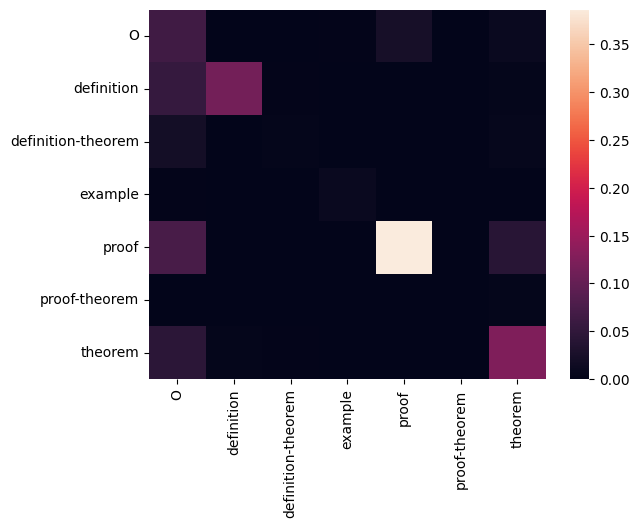

In [97]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = sorted(outputs.golds.unique())
mat = confusion_matrix(outputs.golds, outputs.preds, labels=labels, normalize='all')
sns.heatmap(mat, xticklabels=labels, yticklabels=labels)

In [79]:
outputs.to_csv(f'results/openai-4o-finetuned.both.outputs.csv', sep='\t', index=False)
!column -t -s $'\t' results/openai-4o-finetuned.both.outputs.csv > results/openai-4o-finetuned.both.txt

In [80]:
from seqeval.metrics import f1_score

In [81]:
golds = []
current = None
for g in outputs.golds:
    if g == 'O':
        current = None
        golds.append('O')
    elif g == current:
        golds.append(f'I-{g}')
    else:
        current = g
        golds.append(f"B-{g}")

preds = []
current = None
for p in outputs.preds:
    if p == 'O':
        current = None
        preds.append('O')
    elif p == current:
        preds.append(f'I-{p}')
    else:
        current = p
        preds.append(f"B-{p}")
outputs['bio_golds'] = golds
outputs['bio_preds'] = preds

In [82]:
ps = [chunk for chunk in chunked(outputs.bio_preds, n=1024)]
gs = [chunk for chunk in chunked(outputs.bio_golds, n=1024)]

In [83]:
f1_score(gs, ps, mode=None, average='micro', scheme=IOB2)

0.4055299539170507